![PyTorch logo](img/pytorch.jpg)

# From dummy to state-of-the-art in 60 minutes
By José Fernández Portal

## Agenda
1. Introduction
2. Numpy with superpowers
3. A Deep Learning library
4. Let's rock! (state-of-the-art models with PyTorch)
5. Takeaways

## Target audience
This tutorial assumes audience is familiarized with:
- Python, particularly Numpy.
- Neural nets (models, layers, loss functions, gradient descent, etc.).

Otherwise, it is adviced to review these concepts and then go through the tutorial again.

## Acknowledgements
The contents of this presentations, specially the state-of-the-art models, are heavy based on ideas from Jeremy Howard and his [fast.ai](https://www.fast.ai) course.

## 1. Introduction

### 1.2. What is Pytorch?

- Open-source Deep Learning library.
- Developed by Facebook AI Team.
- Alternative to TensorFlow/Keras.

### 1.2. Why PyTorch?

- 100% pythonic / friendly API.
- Dynamic computational graph.
 - Imperative style.
 - Easy to debug.
- Flexible and extensible.
- Fast and lean.
- Production ready.
- Growing community.  
- Rich ecosystem (fastai, ignite, pyro, etc.).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import PIL.Image as Image
import matplotlib.pyplot as plt
import random
from datetime import datetime
from sklearn.model_selection import train_test_split
from functools import partial
import pdb

## 2. Numpy with superpowers

PyTorch will feel very familiar to Numpy's users...

### 2.1. Basic operations

In [3]:
a = torch.tensor([[5., 3], [4, 1], [3, 6]])  # similar to np.array([[5., 3], [4, 1], [3, 6]])
a, a.shape

(tensor([[5., 3.],
         [4., 1.],
         [3., 6.]]), torch.Size([3, 2]))

In [4]:
b = torch.rand(2, 4)

In [5]:
c = a @ b
c

tensor([[5.6870, 2.6882, 1.2685, 6.4706],
        [3.1554, 1.3402, 0.5809, 4.0680],
        [7.5949, 4.0442, 2.0629, 7.2076]])

In [6]:
c.argmax(dim=1)

tensor([3, 3, 0])

#### Numpy bridge

Going back and forth between PyTorch and Numpy is straightforward.

In [7]:
a = np.random.rand(2, 2)
a

array([[0.27658978, 0.20307404],
       [0.97851281, 0.38392567]])

In [8]:
t = torch.tensor(a) # torch.from_numpy(a)
t

tensor([[0.2766, 0.2031],
        [0.9785, 0.3839]], dtype=torch.float64)

In [9]:
b = (t*10).numpy()
b

array([[2.76589778, 2.03074038],
       [9.78512808, 3.83925666]])

### 2.2. GPU powered

By using PyTorch we can leverage on GPU computing power.

Let's compare the performance of a matrix product among Numpy, PyTorch on CPU and PyTorch on GPU...

In [10]:
N = (7000, 7000) # matrix size

#### Numpy

In [11]:
a = np.random.rand(*N)
b = np.random.rand(*N)

In [12]:
%time c = np.matmul(a, b);

CPU times: user 57.7 s, sys: 580 ms, total: 58.2 s
Wall time: 7.85 s


#### PyTorch on CPU

In [13]:
a = torch.rand(*N)
b = torch.rand(*N)

In [14]:
%time c = a @ b

CPU times: user 6.22 s, sys: 75.6 ms, total: 6.29 s
Wall time: 1.57 s


#### PyTorch on GPU (CUDA)

CUDA: "Compute Unified Device Architecture" (Nvidia's GPU propieraty technology).

In [15]:
a = torch.rand(*N)
b = torch.rand(*N)
a.device, b.device

(device(type='cpu'), device(type='cpu'))

Moving tensors to GPU...

In [16]:
if torch.cuda.is_available():
    a, b = a.cuda(), b.cuda()
a.device, b.device

(device(type='cuda', index=0), device(type='cuda', index=0))

In [17]:
%time c = a @ b
c.device

CPU times: user 0 ns, sys: 5.98 ms, total: 5.98 ms
Wall time: 7 ms


device(type='cuda', index=0)

That's fast!

Moving back to CPU.

In [18]:
c = c.cpu()
c.device

device(type='cpu')

It's a common pattern to move tensors to GPU when available.

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
c = c.to(device)
c.device

device(type='cuda', index=0)

### 2.3. Autograd: automatic differentiation 

PyTorch's Autograd can track for us all the operations applied to a tensor and provides automatic differentiation. This will be a key feature when we train Neural Nets.

In [20]:
x = torch.arange(4., requires_grad=True)
x

tensor([0., 1., 2., 3.], requires_grad=True)

In [21]:
y = x.pow(2)
y.mul_(5)
y.add_(3)
y = y.mean()
# equivalent to: y = (5 * x**2 + 3).mean()

So, our function looks like:

\begin{align} y = \frac{1}{4} \sum_{i=1}^4 5 x_i ^ 2 + 3 \end{align}

If we check the gradient, it is empty by now...

In [22]:
x.grad

By calling `backward()`, gradient is computed.

In [23]:
y.backward()
x.grad

tensor([0.0000, 2.5000, 5.0000, 7.5000])

You can double check analytically that gradient was correcly computed.

\begin{align}
\frac{\partial y}{\partial x_i} = 
\frac{5 x_i}{2} 
\end{align}

By default, PyTorch accumulates the gradient when calling `.backward()` multiple times, so it's important to reset the gradient after calling `backward()`.

In [24]:
x.grad.zero_()
x.grad

tensor([0., 0., 0., 0.])

## 3. A Deep Learning library

PyTorch is also a very powerful and flexible Deep Learning Framework.

Let's begin by creating a simple NN from scratch and refactor it progressively.

### 3.1 Building a logistic regressor from scratch (without torch.nn)

In order to build a NN, we need 4 things:
1. A dataset (features & target).
2. A model.
3. A loss function.
4. An optimization algorith (gradient descent).

So let's go step by step...

#### Dataset (features & target)

We will use MNIST.

In [25]:
PATH = Path('~/datasets/mnist_png').expanduser()

In [26]:
def get_ds(path):
    fnames = list(path.glob('*/*'))
    random.shuffle(fnames)
    
    x = [np.array(Image.open(fn)) for fn in fnames]
    x = torch.tensor(x)
    x = x.view(len(x), -1).float()
    x = (x - x.mean()) / x.std()
    
    y = [int(fn.parent.name) for fn in fnames]
    y = torch.tensor(y)
    
    return x, y

In [27]:
train_x, train_y = get_ds(PATH/'train')
valid_x, valid_y = get_ds(PATH/'test')
train_x.shape, train_y.shape, valid_x.shape, valid_y.shape

(torch.Size([60000, 784]),
 torch.Size([60000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

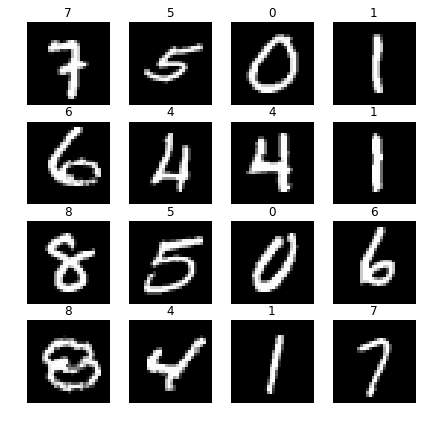

In [28]:
fig, axes = plt.subplots(4, 4, figsize=(7,7))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(train_x[i].view(28,28), cmap='binary_r');
    ax.set_title(train_y[i].item())
    ax.axis('off')

#### Model

In [29]:
def model(x): return torch.log_softmax(x @ weight.t() + bias, dim=1)

weight = torch.randn(10, 784, requires_grad=True)
weight.data /= np.sqrt(784) # Xavier initialization
bias = torch.zeros(10, requires_grad=True)

#### Loss function

In [30]:
def nll_loss(input, target): return -input[range(target.shape[0]), target].mean()
loss_func = nll_loss

#### Optimization algorith (Gradient Descent)

In [31]:
lr = 1e-1
epochs = 100

CPU times: user 24.4 s, sys: 42.4 ms, total: 24.4 s
Wall time: 4.6 s


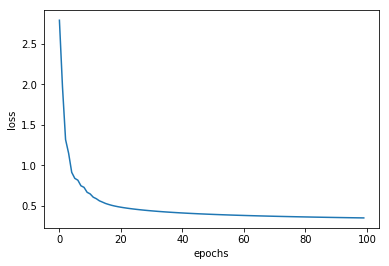

In [32]:
%%time
losses = []
for i in range(epochs):
    y_hat = model(train_x)
    loss = nll_loss(y_hat, train_y)
    loss.backward()
    with torch.no_grad():
        weight -= weight.grad * lr
        bias -= bias.grad * lr
        weight.grad.zero_()
        bias.grad.zero_()
    losses.append(loss.item())
    
plt.plot(losses);
plt.xlabel('epochs'); plt.ylabel('loss');

#### Predicting

In [33]:
def accuracy(input, target):
    preds = input.argmax(dim=1)
    return (preds==target).float().mean().item()

In [34]:
preds = model(valid_x)
accuracy(preds, valid_y)

0.9067999720573425

### 2.2. Refactoring with torch.nn and torch.optim

#### Dataset
By now, let's continue using the same dataset.

#### Model

PyTorch provides two alternatives APIs to define a model. We can use any of them:
- Declarative API:

In [35]:
model = nn.Sequential(nn.Linear(784, 10),
                      nn.LogSoftmax(dim=1))

- Functional API (usually for complex or custom models/layers):

In [40]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, x):
        x = self.lin(x)
        x = F.log_softmax(x, dim=1)
        return x
    
model = Model()

#### Loss function

In [41]:
loss_func = nn.NLLLoss()

#### Optimization algorithm

In [42]:
epochs = 100
opt = optim.Adam(model.parameters(), lr=1e-2)

CPU times: user 23.2 s, sys: 21.2 ms, total: 23.2 s
Wall time: 4.32 s


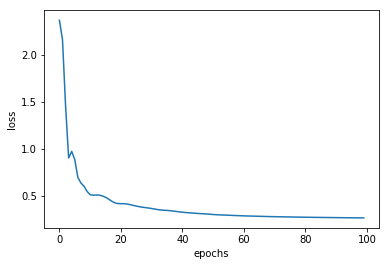

In [43]:
%%time
losses = []
for i in range(epochs):
    y_hat = model(train_x)
    loss = loss_func(y_hat, train_y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    losses.append(loss.item())
    
plt.plot(losses);
plt.xlabel('epochs'); plt.ylabel('loss');

#### Predicting

In [44]:
preds = model(valid_x)
accuracy(preds, valid_y)

0.9222999811172485

### 2.3. Data objects

Up to now, we have been using vanilla gradient descent, instead of Stocastic Gradient Descent (SGD), which makes training slow for two reasons:
- We are just updating the weights only once per epoch.
- We can not leverage on GPU, since train set is too big to fit in memory at once.

It doesn't look that bad for this toy dataset/model, but it would make training terrible slow for larger datasets/models.

So let's introduce PyTorch's data objects...

In [45]:
PATH = Path('~/datasets/mnist_png/').expanduser()
BS = 256

#### Transform
As its name suggests, it allows to transform the data as required to fit in our model. We will use it later to perform data augmentation as well.

In [46]:
tfms = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))])

#### Datasets

Datasets help us loading data on demand. PyTorch provides different kinds of datasets for specific types of data, or you can create your custom dataset when required.

In [47]:
!ls {PATH/'train'}

0  1  2  3  4  5  6  7	8  9


In [48]:
train_ds = torchvision.datasets.ImageFolder(PATH/'train', tfms)
valid_ds = torchvision.datasets.ImageFolder(PATH/'test', tfms)
len(train_ds), len(valid_ds), train_ds.classes

(60000, 10000, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [49]:
x, y = train_ds[0]
x.shape, y

(torch.Size([1, 28, 28]), 0)

#### Dataloaders

A dataloader turns a dataset into a generator that yield data in batches. It is ideal to perform Stochastic Gradient Descent (or any its variant), specially when training on GPU where only limited amount of data can fit into memory.

In [50]:
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True, num_workers=8)
valid_dl = DataLoader(valid_ds, batch_size=BS*8, shuffle=False, num_workers=8)
it = iter(train_dl)

In [51]:
xb, yb = next(it)
xb.shape, yb.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

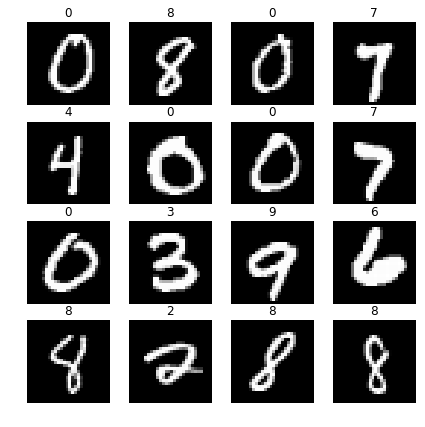

In [52]:
fig, axes = plt.subplots(4, 4, figsize=(7, 7))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(xb[i].squeeze(), cmap='binary_r');
    ax.set_title(yb[i].item())
    ax.axis('off')

### 2.4. Final refactor

#### Training loop

Let's put all together and write a generic training loop. We will be reusing it for the rest of the tutorial.

In [53]:
def fit(epochs, model, opt, loss_fn, train_dl, valid_dl, metric=None):
    # *** MOVE MODEL TO GPU ***
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    # PyTorch LR scheduler performs learning rate annealing to boost training performance (optional)
    lr_sched = optim.lr_scheduler.CosineAnnealingLR(opt, len(train_dl)*epochs, 
                                                    eta_min=opt.defaults['lr']/1e6)
    train_start = datetime.now()
    
    # *** TRAINING LOOP ***
    for epoch in range(epochs):
        train_loss, valid_loss, valid_metric = 0., 0., 0.
        
        # *** TRAIN ***
        model.train()
        for xb, yb in train_dl:                     # iterate every batch
            xb, yb = xb.to(device), yb.to(device)   # move features and target to GPU
            output = model(xb)                      # predict
            loss = loss_fn(output, yb)              # compute loss
            loss.backward()                         # backprop
            opt.step()                              # adjust weights
            opt.zero_grad()
            lr_sched.step()                              
            train_loss += loss.item() * len(xb)
            
        # *** VALIDATION ***
        model.eval()
        for xb, yb in valid_dl:
            xb, yb = xb.to(device), yb.to(device)
            with torch.no_grad(): output = model(xb)
            loss = loss_fn(output, yb)
            if metric: valid_loss += loss.item() * len(xb)
            valid_metric += metric(output, yb) * len(xb)
   
    # compute metrics and print
        train_loss /= len(train_dl.dataset)
        valid_loss /= len(valid_dl.dataset)
        valid_metric /= len(valid_dl.dataset)
        if epoch==0: print(f'epoch  train_loss  valid_loss  valid_metric')
        print(f'{epoch+1:<7}{train_loss:<12.6f}{valid_loss:<12.6f}{valid_metric:<12.6f}')
    train_elapsed = datetime.now() - train_start
    print(f'Total time: {train_elapsed.seconds} seg.')

#### Final model

In [54]:
class Flatten(nn.Module): 
    def forward(self, x): return x.view(x.shape[0], -1)
    
def linear_block(ni, nf):
    return nn.Sequential(nn.Linear(ni, nf),
                         nn.ReLU(),
                         nn.BatchNorm1d(nf))

model = nn.Sequential(Flatten(),               
                      linear_block(784, 512),
                      linear_block(512, 512),
                      nn.Linear(512, 10),
                      nn.LogSoftmax(dim=1))

In [55]:
#model

#### Train

In [58]:
loss_func = nn.NLLLoss()
opt = optim.Adam(model.parameters(), 1e-3)
metric = accuracy

In [59]:
fit(2, model, opt, loss_func, train_dl, valid_dl, metric)

epoch  train_loss  valid_loss  valid_metric
1      0.074851    0.070460    0.977100    
2      0.029356    0.054470    0.982100    
Total time: 5 seg.


~98% accuracy in few seconds!

## 3. Let's rock!

This section aims to provide a quick bird's-eye view of how powerful models can be implemented with PyTorch.

### 3.1. Building a dog & cat breeds classifier (Oxford IIIT Pet dataset)

#### Data

In [60]:
PATH = Path('~/datasets/oxford-iiit-pet/images').expanduser()
IMG_SZ = 354
BS = 64

In [61]:
fnames = list(PATH.glob('*.jpg'))
labels = [fn.name.rsplit('_', 1)[0] for fn in fnames]

train_fns, valid_fns, train_lbls, valid_lbls = train_test_split(
    fnames, labels, test_size=0.2, random_state=13)

Custom dataset that receives images' filenames and labels.

In [62]:
class ImageDataset(Dataset):
    def __init__(self, fnames, labels, tfms, classes=None):
        self.fnames = fnames
        self.classes = classes or sorted(set(labels))
        self.cls2idx = {c:i for i,c in enumerate(self.classes)}
        self.labels = [self.cls2idx[lbl] for lbl in labels]
        self.tfms = tfms 

    def __len__(self): return len(self.fnames)
    
    def __getitem__(self, idx):
        img = Image.open(self.fnames[idx])
        if img.mode != 'RGB': img = img.convert('RGB')
        return self.tfms(img), self.labels[idx]

Transforms:
- With data augmentation for train set.
- Without data augmentation for validation set.

In [63]:
imagenet_stats = {'mean':[0.485, 0.456, 0.406], 'std':[0.229, 0.224, 0.225]}

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SZ, scale=(0.9,1.1), ratio=(1.,1.)),
    transforms.ColorJitter(0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(**imagenet_stats)])

valid_tfms = transforms.Compose([
    transforms.Resize(IMG_SZ),
    transforms.CenterCrop(IMG_SZ),
    transforms.ToTensor(),
    transforms.Normalize(**imagenet_stats)])

In [64]:
train_ds = ImageDataset(train_fns, train_lbls, train_tfms)
valid_ds = ImageDataset(valid_fns, valid_lbls, valid_tfms, classes=train_ds.classes)
classes = train_ds.classes
len(train_ds), len(valid_ds), len(classes)

(5912, 1478, 37)

In [65]:
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=BS*2, shuffle=False, num_workers=4)

In [66]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([64, 3, 354, 354]), torch.Size([64]))

Plot images

In [67]:
def tensor_to_image(t): 
    tfms = transforms.Compose([
        transforms.Normalize([0, 0, 0], 1/torch.tensor(imagenet_stats['std'])),
        transforms.Normalize(-torch.tensor(imagenet_stats['mean']), [1, 1, 1]),
        transforms.ToPILImage()])
    return tfms(t.clone())

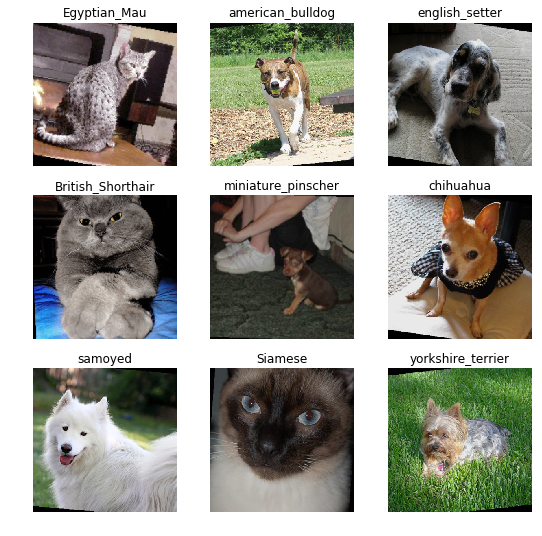

In [68]:
fig, axes = plt.subplots(3, 3, figsize=(9,9))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(tensor_to_image(xb[i]));
    ax.set_title(classes[yb[i].item()])
    ax.axis('off')

#### Model (ResNet + transfer learning)

Load a ResNet34 pretrained model.

![Resnet34](img/resnet.png)

In [69]:
model = torchvision.models.resnet34(pretrained=True)

In [70]:
#model

Replace the last layers...

In [71]:
class AdaptiveConcatPool2d(nn.Module):
    def forward(self, x): 
        avg_pool,max_pool = F.adaptive_avg_pool2d(x, 1), F.adaptive_max_pool2d(x, 1)
        return torch.cat([avg_pool, max_pool], dim=1)
    
class Flatten(nn.Module):  
    def forward(self, x): return x.view(x.shape[0], -1)

In [72]:
conv = nn.Sequential(*list(model.children())[:-2])
fc = nn.Sequential(AdaptiveConcatPool2d(),
                   Flatten(),
                   nn.BatchNorm1d(1024),
                   nn.Dropout(0.25),
                   nn.Linear(1024, 512),
                   nn.ReLU(),
                   nn.BatchNorm1d(512),
                   nn.Dropout(0.5),
                   nn.Linear(512, len(train_ds.classes)),
                   nn.LogSoftmax(dim=1))

model = nn.Sequential(conv, fc)

In [73]:
#model

#### Training

Freeze the convolutional section of the network (already pre-trained) and train the last layers only.

In [74]:
# freeze
for p in model[0].parameters(): p.requires_grad = False

In [75]:
def accuracy(input, target):
    preds = input.argmax(dim=1)
    return (preds==target).float().mean().item()

In [76]:
loss_fn = nn.NLLLoss()
metric = accuracy

In [77]:
opt = optim.Adam(model.parameters(), lr=3e-3)
fit(4, model, opt, loss_fn, train_dl, valid_dl, metric)

epoch  train_loss  valid_loss  valid_metric
1      0.756890    0.263767    0.922869    
2      0.278624    0.216168    0.930311    
3      0.193565    0.212558    0.926252    
4      0.164883    0.202218    0.933694    
Total time: 103 seg.


In [78]:
#stage1 = model.state_dict()
#model.load_state_dict(stage1)

Now, unfreeze the convolutional section for fine-tunning.

In [79]:
# unfreeze
for p in model.parameters(): p.requires_grad = True

In [80]:
opt = optim.Adam(model.parameters(), lr=3e-5)
fit(1, model, opt, loss_fn, train_dl, valid_dl, metric)

epoch  train_loss  valid_loss  valid_metric
1      0.165292    0.177621    0.940460    
Total time: 54 seg.


In [81]:
#torch.save(model.state_dict(), 'oxford-pet-trained')
#model.load_state_dict(torch.load('oxford-pet-trained'))

#### Predict

Let's try with Bruno, my dog.

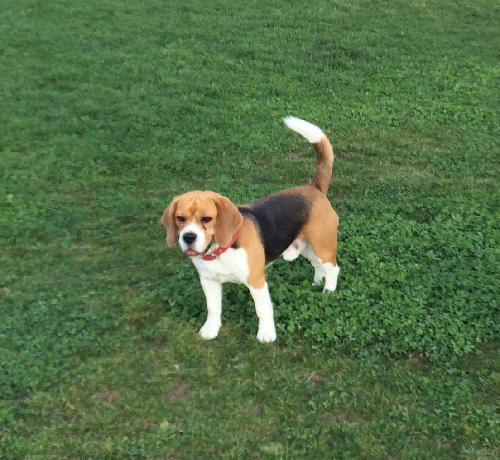

In [82]:
fname = 'img/bruno.jpg'
img = Image.open(fname)
img

In [83]:
def image2tensor(img, target_sz):
    tfms = transforms.Compose([
        transforms.Resize(target_sz),
        transforms.CenterCrop(target_sz),
        transforms.ToTensor(),
        transforms.Normalize(**imagenet_stats)])
    return tfms(img)[None]

x = image2tensor(img, IMG_SZ)
x.shape

torch.Size([1, 3, 354, 354])

In [84]:
model = model.cpu().eval()
pred = model(x)

In [85]:
log_prob, cls_idx = pred.max(1)
classes[cls_idx], log_prob.exp().item()

('beagle', 0.9997521042823792)

Great! Bruno seems to be a beagle with a 99.9% confidence.

#### Opening the black box... (Grad-CAM)

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

PyTorch's hooks allow to obtain activations and gradient of any given layer. 

In this case, we will hook the convotutional section of the NN.

In [86]:
def get_hooks(y=None):
    def hook(module, input, output, append_to):
        append_to.append(output)       

    acts, grad = [], []
    h_fwd = model[0].register_forward_hook(partial(hook, append_to=acts))
    h_bwd = model[0].register_backward_hook(partial(hook, append_to=grad))
    preds = model(x)
    if y is None: y = preds.argmax(1)[0]
    preds[0, y].backward()
    h_fwd.remove(), h_bwd.remove();
    return acts[0].squeeze().data, grad[0][0].squeeze()

In [87]:
acts, grad = get_hooks()
avg_grad = grad.mean(1).mean(1)
acts.shape, avg_grad.shape

(torch.Size([512, 12, 12]), torch.Size([512]))

Now we have the activations and the gradient:
- These activations represent how different parts of the image activate each of the 512 features.
- The gradient (averaged by feature) represents the relative importance of each feature to predict a given target.

By multiplying both, we get the activations by region and weighted by feature importance (grad).

In [88]:
hm = (acts * avg_grad[:,None,None]).mean(0)
hm.shape

torch.Size([12, 12])

Now we can plot it, to undertand visualize the parts of the image that were relevant for the classification.

In [89]:
def show_heatmap(img, hm):
    plt.figure(figsize=(6,6))
    plt.imshow(img);
    plt.imshow(hm, extent=(0,*img.size,0), interpolation='bilinear', alpha=.6, cmap='magma');
    plt.axis('off')

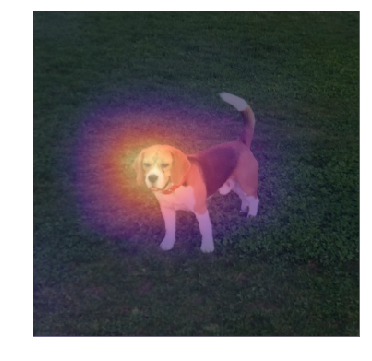

In [90]:
show_heatmap(tensor_to_image(x[0]), hm)

Let's try something harder...

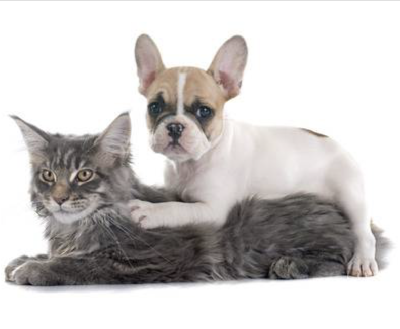

In [91]:
img = Image.open('img/bulldog_maine.png')
img

In [92]:
x = image2tensor(img, IMG_SZ)

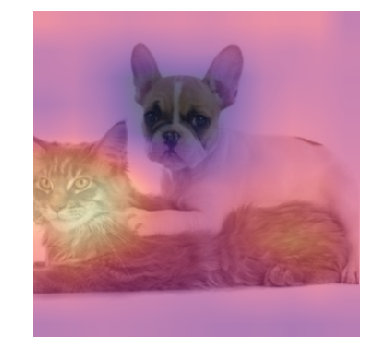

In [93]:
acts, grad = get_hooks()
avg_grad = grad.mean(1).mean(1)
hm = (acts * avg_grad[:,None,None]).mean(0)
show_heatmap(tensor_to_image(x[0]), hm)

The classifier is detecting a Maine Coon cat, so the focus is on it.

What if we now tell explicitly to out NN that this image should be classified as an American Bulldog instead of a Maine Coon?

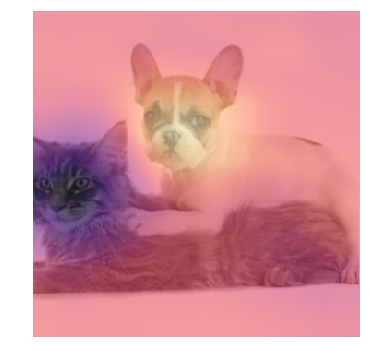

In [94]:
y = train_ds.cls2idx['american_bulldog']

acts, grad = get_hooks(y)
avg_grad = grad.mean(1).mean(1)
hm = (acts * avg_grad[:,None,None]).mean(0)
show_heatmap(tensor_to_image(x[0]), hm)

BOOM! The gradient now is saying the model, not to focus on the cat's features, but on the dog's features.

### 3.2. Building a recommendation system (MovieLens 1M dataset)

#### Data

In [95]:
BS = 1024
PATH = Path('~/datasets/ml-1m/ratings.dat').expanduser()

In [96]:
ratings = pd.read_csv(PATH, delimiter='::', header=None, engine='python', 
                      names=['userId', 'movieId', 'rating'], index_col=False, 
                      dtype={'userId': 'category', 'movieId': 'category', 'rating':'float'})
ratings.head()

,userId,movieId,rating
0,1,1193,5.0
1,1,661,3.0
2,1,914,3.0
3,1,3408,4.0
4,1,2355,5.0


In [97]:
n_users, n_movies = len(ratings.userId.cat.categories), len(ratings.movieId.cat.categories)
n_users, n_movies, len(ratings), len(ratings)/(n_users*n_movies)

(6040, 3706, 1000209, 0.044683625622312845)

In [98]:
x = ratings[['userId', 'movieId']].apply(lambda x: x.cat.codes).values
y = ratings['rating'].values

train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.2, random_state=13)

In [99]:
train_ds = TensorDataset(torch.LongTensor(train_x), torch.FloatTensor(train_y))
valid_ds = TensorDataset(torch.LongTensor(valid_x), torch.FloatTensor(valid_y))
len(train_ds), len(valid_ds)

(800167, 200042)

In [100]:
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BS*2, shuffle=False)

In [101]:
xb, yb = next(iter(valid_dl))
list(zip(xb[:5], yb[:5]))

[(tensor([3788,  313]), tensor(3.)),
 (tensor([3060,  267]), tensor(5.)),
 (tensor([3491, 2838]), tensor(3.)),
 (tensor([1090,  355]), tensor(4.)),
 (tensor([ 847, 1383]), tensor(3.))]

#### Model (Collaborative filtering with Statistical Matrix Factorization and normalized output)

![Statistical Matrix Factorization](img/collab.png)

In [102]:
class CollabModel(nn.Module):
    def __init__(self, n_factors, n_users, n_movies, y_range):
        super().__init__()
        self.user_wgts = nn.Embedding(n_users, n_factors)
        self.user_bias = nn.Embedding(n_users, 1)
        self.movie_wgts = nn.Embedding(n_movies, n_factors)
        self.movie_bias = nn.Embedding(n_movies, 1)
        self.y_min,self.y_max = y_range
        # weights initialization
        for e in (self.user_wgts, self.movie_wgts, self.user_bias, self.movie_bias):
            with torch.no_grad(): e.weight.normal_().fmod_(2).mul_(0.01).add_(0.)
    
    def forward(self, x):
        users, movies = x[:,0], x[:,1]
        dot = (self.user_wgts(users) * self.movie_wgts(movies)).sum(dim=1)
        res = dot + self.user_bias(users) + self.movie_bias(movies)
        return torch.sigmoid(res) * (self.y_max-self.y_min) + self.y_min

In [103]:
model = CollabModel(n_factors=250, n_users=n_users, n_movies=n_movies, y_range=(0., 6.))

In [104]:
#model

#### Train

In [105]:
def RMSE(input, target): return (input-target).pow(2).mean().sqrt()

In [106]:
loss_fn = nn.MSELoss()
metric = RMSE
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=1e-5)

In [107]:
fit(6, model, opt, loss_fn, train_dl, valid_dl, metric)

epoch  train_loss  valid_loss  valid_metric
1      1.010204    0.797081    0.892666    
2      0.728605    0.738340    0.859141    
3      0.632019    0.716880    0.846565    
4      0.554583    0.709642    0.842278    
5      0.504957    0.707860    0.841220    
6      0.483854    0.707685    0.841116    
Total time: 36 seg.


Let's compare with [LibRec's benchmark](https://www.librec.net/release/v1.3/example.html)...

WOW! This is a SotA model! (all the credit to Jeremy Howard).

## Takeaways

- **PyTorch is so pythonic.** 🐍❤️
- **It makes it easy to work with NNs.** 🧠
- **It keeps you on the driver's seat.** 🤓
- **So powerful!** 💪

 - **Bunus takeaway:** Demystifing Deep Learning...
  - Myth 1: "Deep Learning is a black box." **False! There are techniques that help understanding what is going on under the hood.**
  - Myth 2: "Deep Learning is only for images and NLP." **False! DL is SotA for structured data as well (tabular data, recommendation systems, etc.)**

## End!